# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [3]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Прочитаем исходные данные:

In [4]:
data = pd.read_csv('unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


Признаки в данных:

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс (кг/м2 *10e6);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [5]:
# checking datatypes and searching for null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


> NO null values presented, dataset contain only numeric data.

In [6]:
# Distribution visualization

def distribution_fig(data, column):
    """Building histogram for distribution visualization.

    Args:
        data (DataFrame):  DataFrame for visualization.
        column (str): feature for visualization.

    Returns:
        fig: histogram for distribution 
    """
    
    # building histogram
    fig = px.histogram(
        data_frame=data,
        x=column,
        title='',
        width=600,
        height=400,
        marginal='box'
    )
    fig.update_layout(title='Distribution of {}'.format(column))
    
    return fig.show()
# Building a distribution plot for reviewer_score for training data only
distribution_fig(data, 'Prod')

> The distribution of target feature have no outliers, symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far from the mean. 

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Matrix rank: 8
Matrix determinant: 0.00073


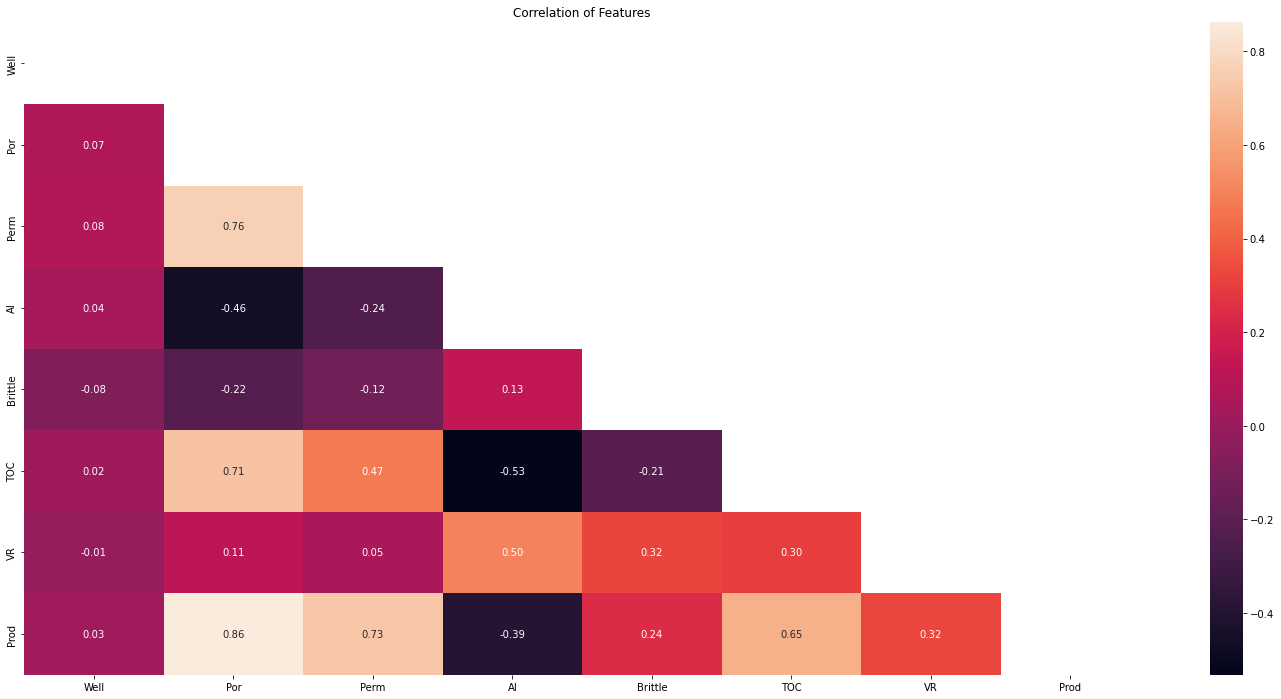

In [7]:
# correlation matrix
fig = plt.figure(figsize=(25, 12))
corr = data.corr()
mask = np.triu(np.ones_like(corr))
heatmap = sns.heatmap(corr, mask=mask, fmt='.2f', annot=True)
heatmap.set_title('Correlation of Features');

print('Matrix rank: {}\nMatrix determinant: {}'.format(np.linalg.matrix_rank(corr), np.linalg.det(corr).round(5)))

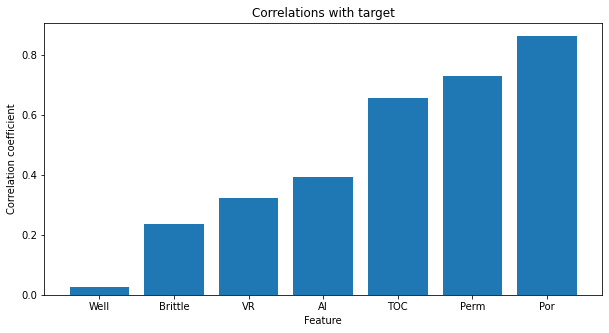

In [8]:
# correlation with target feature
corr_with_target = data.corr()['Prod'].abs().sort_values()
corr_with_target = corr_with_target.drop('Prod')
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(corr_with_target.index, corr_with_target.values) 
ax.set_title('Correlations with target') 
ax.set_xlabel('Feature') 
ax.set_ylabel('Сorrelation coefficient'); 

> Корреляционная матрица близка к вырожденной и плохо обусловлена так, как определитель близок к 0. 
>
> Матрица симметрична, поэтому матрица отображена без диагонали и повторяющихся пар. 
>
> Ранг матрицы - 8. В данном случае применима модель классической линейной регрессии по методу наименьших квадратов потому, что нет линейно зависимых факторов, матрица корреляции не вырожденная так, как имеет максимальный ранг.
> Присутствует несколько мультиколлинеарных факторов Por с TOC и Perm.
> Лучшим решением будет удаление факторов с наиболее сильной корреляцией целевой переменной Prod: Por, Perm, TOC.


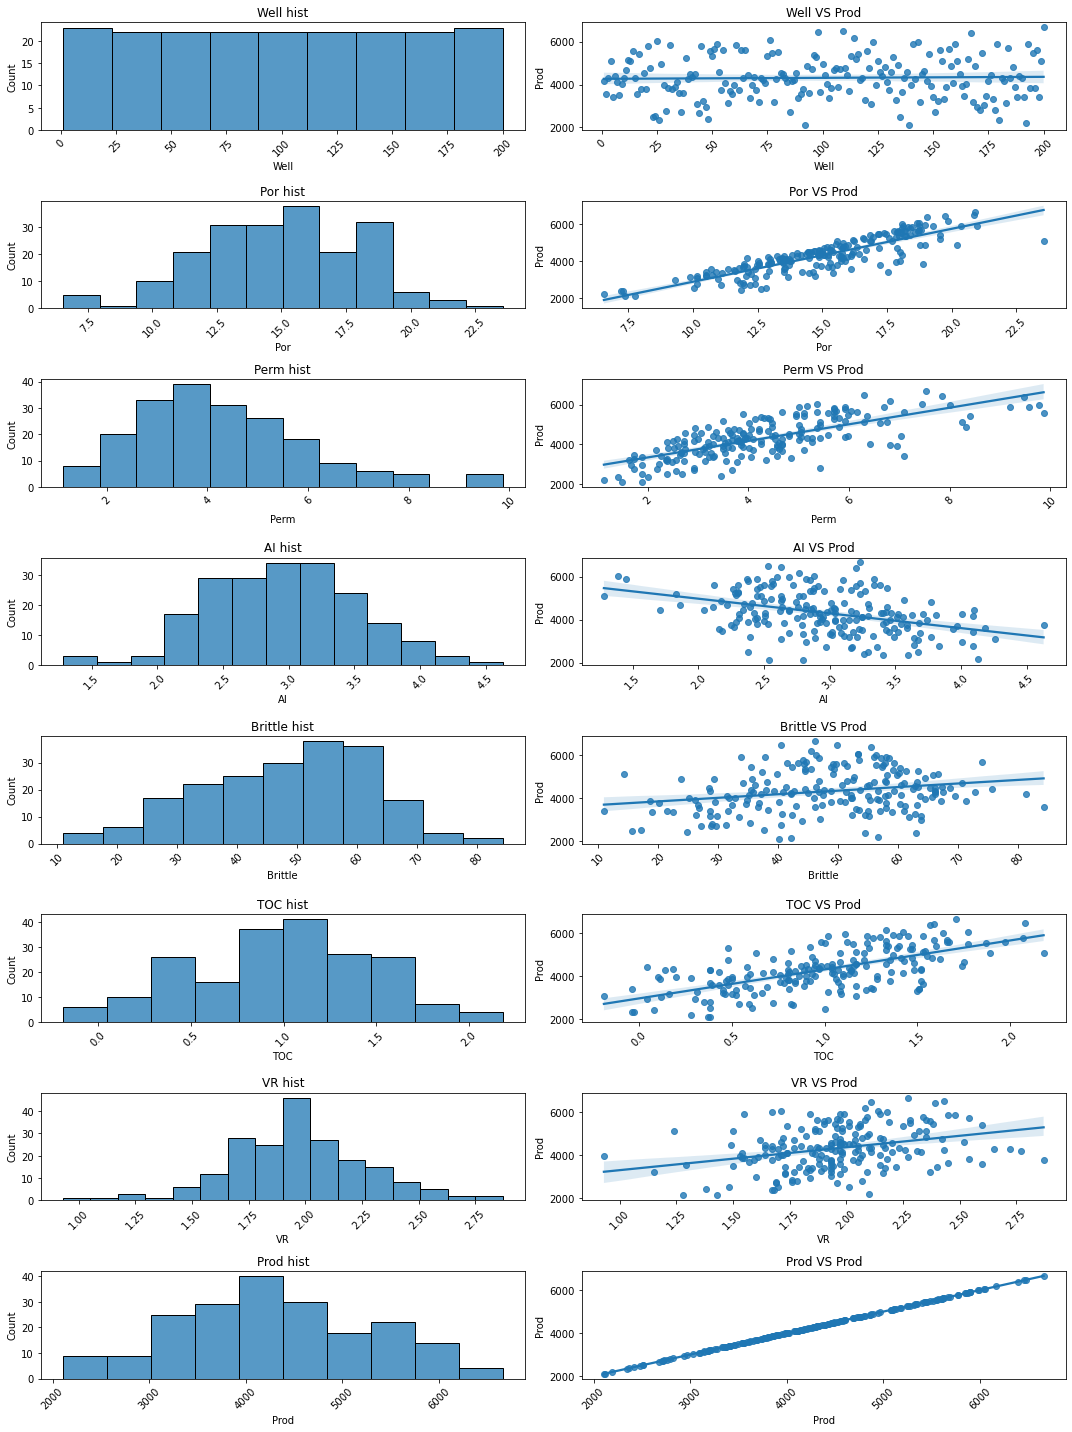

In [9]:
# Descriptive statistics for quantitative variables
n = len(data.columns) 
fig, axes = plt.subplots(n, 2, figsize=(15, 20))
for i, feature in enumerate(data.columns): 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    histplot.set_title('{} hist'.format(feature))
    histplot.xaxis.set_tick_params(rotation=45)
    regplot = sns.regplot(data=data, x=feature, y='Prod', ax=axes[i][1])
    regplot.set_title('{} VS Prod'.format(feature));
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() 

>Между целевым фактором и факторами Por, Perm, TOC - наблюдается достаточно сильная корреляция. 

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [10]:
X = np.column_stack((np.ones(len(data)), data.values[:,0:-1]))
y = data[['Prod']]

w_hat =np.linalg.inv(X.T@X)@X.T@y
print(w_hat.values.round())

[[-1232.]
 [    0.]
 [  230.]
 [  116.]
 [ -365.]
 [   25.]
 [  -78.]
 [  785.]]


> Признак Well является неинформативным и не оказывает влияния на целевую переменную.
>
> Значение коэффициента означает, на сколько в среднем измениться медианная добыча млн. куб. футов газа в сутки - mcf/day.
>
> При увеличении на 1% пористости скважины [Por] или коэффициента отражения витринита [VR], количество добываемого газа среднем увеличится на 230 млн. куб. футов в сутки или на 785 млн. куб. футов в сутки соответственно. При увеличении акустического импенданса [AI] на 1 кг/м2 *10e6 количество добываемого газа среднем уменьшиться на 365 млн. куб. футов в сутки.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [11]:
new_data = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42}

In [12]:
# prediction for new data
new = np.array([1] + list(new_data.values()))

prod_pred = new@w_hat

# absolute error
print('Absolute error for prediction: ',4748.315024-prod_pred.values)

# prediction for all dataset
print('Prediction for all dataset')
y_predict = X@w_hat.values


# Mean absolute error
mae_error = np.mean(np.abs(y - y_predict))
print('Mean absolute error', mae_error.values)

# Mean absolute percentage error
mape_error =  np.mean(np.abs((y - y_predict) / y) * 100)
print('Mean absolute percentage error: {} %'.format(mape_error.values.round(2)))

Absolute error for prediction:  [25.25097029]
Prediction for all dataset
Mean absolute error [153.62297087]
Mean absolute percentage error: [3.63] %


> Абсолютная ошибка построенного прогноза для новой предложенной скважины равна 25 mcf/day (миллион кубических футов в день).
Для максимального понимания результат на всем датасете выбраны метрики оценки качества MAE и MAPE.
Прогноз выработки газа для всех скважин из обучающего набора данных показал среднюю абсолютную ошибку MAE = 153.6 mcf/day, что соответствует средней абсолютной процентной ошибке MAPE = 3.63 %

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

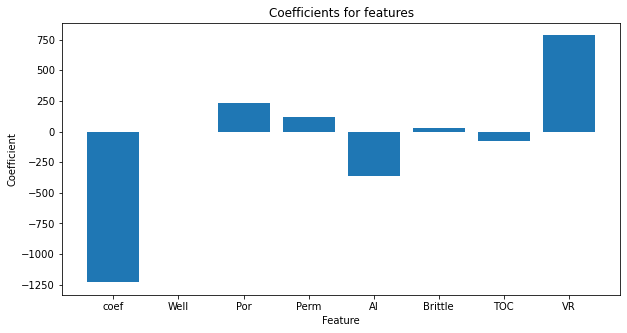

In [13]:
# barplot of coefficients
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.bar(['coef', 'Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR'],
       w_hat['Prod'].values) 
ax.set_title('Сoefficients for features') 
ax.set_xlabel('Feature') 
ax.set_ylabel('Coefficient');

<AxesSubplot:xlabel='TOC', ylabel='Prod'>

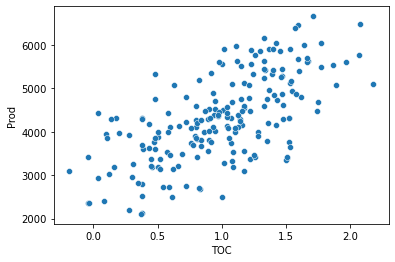

In [14]:
sns.scatterplot(x='TOC', y='Prod', data=data)

In [15]:
data.describe()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,14.991150,4.330750,2.968850,48.161950,0.990450,1.964300,4311.219852
std,57.879185,2.971176,1.731014,0.566885,14.129455,0.481588,0.300827,992.038414
min,1.000000,6.550000,1.130000,1.280000,10.940000,-0.190000,0.930000,2107.139414
25%,50.750000,12.912500,3.122500,2.547500,37.755000,0.617500,1.770000,3618.064513
50%,100.500000,15.070000,4.035000,2.955000,49.510000,1.030000,1.960000,4284.687348
75%,150.250000,17.402500,5.287500,3.345000,58.262500,1.350000,2.142500,5086.089761
max,200.000000,23.550000,9.870000,4.630000,84.330000,2.180000,2.870000,6662.622385


> Коэффициент TOC противоречит соответствующему коэффициенту корреляции. Согласно построенной модели, зависимость между процентом органического углерода и производительностью скважины обратная. Однако, согласно положительному коэффициенту корреляции между этим фактором и целевым признаком, равным 0.65 (а также согласно реальным фактам из сферы добычи газа), зависимость должна быть прямой.
>
>Из графика видно, что зависимость прямая и линейная. Наличие этой сильной мультиколлинеарности в данных «портит» коэффициенты.
>
>Несоответствие масштабов переменных вызывает случай, когда коэффициент фактора обратен коэффициенту корреляции между этим фактором и целевым признаком.  Если предиктор (фактор) и целевой признак имеют разные масштабы или единицы измерения, то коэффициент фактора в линейной регрессии может отличаться от коэффициента корреляции. 
>
>Решение - стандартизация признаков.


### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [16]:
data_2 = data.drop(['Well', 'Perm', 'TOC'], axis=1)
X_2 = np.column_stack((np.ones(len(data_2)), data_2.values[:,0:-1]))
y_2 = data_2[['Prod']]

w_hat_2 =np.linalg.inv(X_2.T@X_2)@X_2.T@y_2

print('New coefficients', w_hat_2.round())

y_predict_2 = X_2@w_hat_2.values

print('Mean absolute error', np.mean(np.abs(y_2 - y_predict_2)).values)

print('Mean absolute percentage error: {} %'.format(
    (np.mean(np.abs((y_2 - y_predict_2) / y) * 100)).values.round(2)))



New coefficients      Prod
0 -1835.0
1   293.0
2  -200.0
3    28.0
4   517.0
Mean absolute error [171.4314606]
Mean absolute percentage error: [4.04] %


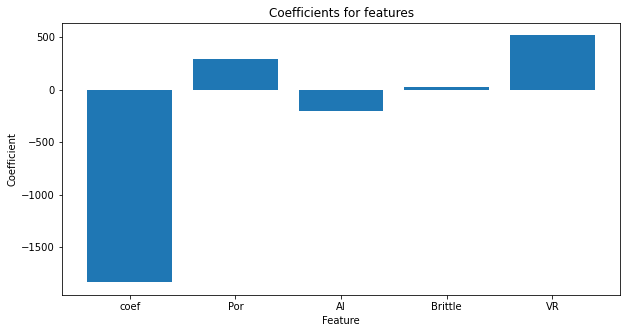

In [17]:
# barplot of coefficients
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.bar(['coef', 'Por', 'AI', 'Brittle', 'VR'],
       w_hat_2['Prod'].values) 
ax.set_title('Сoefficients for features') 
ax.set_xlabel('Feature') 
ax.set_ylabel('Coefficient');

> С новыми коэффициентами увеличение на 1% пористости скважины [Por] увеличит количество добываемого газа среднем на 293 млн. куб. футов в сутки, что больше чем при коэффициентах полученных ранние (230 млн. куб. футов в сутки).
>Увеличение на 1% коэффициента отражения витринита [VR] увеличивало добычу газа на 785 млн. куб. футов в сутки, но всего на 517  млн. куб. футов в сутки при новых коэффициентах.
>При увеличении акустического импенданса [AI] на 1 кг/м2 *10e6 количество добываемого газа среднем уменьшиться на 200 млн. куб. футов в сутки, что лучше, чем 365 млн. куб. футов в сутки при старых коэффициентах.
>  Коэффициент для коэффициента хрупкости скважины [Brittle] приобрел минимальные изменением с 25% к 28%.
>
> После исключите из данных сильно коррелированных между собой факторов добиться прироста метрик не удалось.
>
>Результат на всех данных:
>* Mean absolute error [153.62297087]
>* Mean absolute percentage error: [3.63]
>
>Результат на обновлённых после удаления факторов данных:
>* Mean absolute error [171.4314606]
>* Mean absolute percentage error: [4.04] %
>
>  Удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции, знаки корреляций совпадают со знаками коэффициентов регрессии.



### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = data_2.drop('Prod', axis=1)
y = data_2[['Prod']]

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)

print('MAE: {:.7f}'.format(metrics.mean_absolute_error(y, y_pred)))
print('MAPE: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y, y_pred)*100))

MAE: 171.4314606
MAPE: 4.04 %


> Результат полученный с помощью библиотеки sklearn полностью соответствует полученному в прогнозе вручную с использованием матричной формулы и библиотеки numpy. 

In [19]:
#  таблица, в которую необходимо свести все результаты рассмотренных регрессионных моделей (задание 8.5)
results_df = pd.DataFrame(index = ['Model',
                                   'Params',
                                   'PolynomialFeatures',
                                   'MAPE_train_score',
                                   'MAPE_test_score'])

results_df[0] = [lr,
                 'default',
                 False,
                 metrics.mean_absolute_percentage_error(y, y_pred)*100,
                 None]



def results_log(df, cv_results):
    """Logging results of cross-validation.

    Args:
        df (DataFrame): previous results
        cv_results (dict): results of cross-validation

    Returns:
        _type_: _description_
    """
    df[len(results_df.columns)] = [
                cv_results['estimator'][0], # Model
                cv_results['estimator'][0].get_params(), # Params
                data_2.drop('Prod', axis=1).shape[1] != X.shape[1], # PolynomialFeatures True/False
                -cv_results['train_score'].mean()* 100, # MAPE on train_score
                -cv_results['test_score'].mean() * 100 # MAPE on train_score
    ]

    return df

results_df

,0
Model,LinearRegression()
Params,default
PolynomialFeatures,False
MAPE_train_score,4.044138
MAPE_test_score,None


## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [20]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [21]:
# LinearRegression model on StandartScaled Polynomial features

X = data_2.drop('Prod', axis=1)
y = data_2[['Prod']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X = poly.fit_transform(X)
print('Count of polynomial features', X.shape[1])

lin_reg = LinearRegression()

cv_results = cross_validate(
    lin_reg, X, y, scoring ='neg_mean_absolute_percentage_error', cv=5, return_train_score=True, return_estimator=True)


print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))	


# logging results
results_log(results_df, cv_results)


Count of polynomial features 34
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.68 %


,0,1
Model,LinearRegression(),LinearRegression()
Params,default,"{'copy_X': True, 'fit_intercept': True, 'n_job..."
PolynomialFeatures,False,True
MAPE_train_score,4.044138,1.77324
MAPE_test_score,None,2.680875


> Далее за основную метрику взята cредняя абсолютная процентная ошибка - MAPE.
После стандартизации и генерации полиномиальных признаков ошибка MAPE на тренировочных данных улучшилась  c 4.04 % до 1.77 % при значении в 2.68 % на валидационных фолдах.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
# model with l1 regularization (Lasso) and grid search of parameters
param_grid = {'alpha': list(np.linspace(0.1, 10, 10, dtype=float)),
                       'max_iter': list(range(1000, 11000, 1000))}

grid_search = GridSearchCV(
    estimator=Lasso(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring ='neg_mean_absolute_percentage_error',
    return_train_score=True
)

grid_search.fit(X, y)


print('Best parameters: {}'.format(grid_search.best_params_))

# обучаем модель с лучшими параметрами
lasso = Lasso(
    alpha=grid_search.best_params_['alpha'], max_iter=grid_search.best_params_['max_iter'])

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(
    lasso, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True, return_estimator=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))



# logging results
results_log(results_df, cv_results)

Best parameters: {'alpha': 4.5, 'max_iter': 1000}
MAPE на тренировочных фолдах: 1.82 %
MAPE на валидационных фолдах: 2.28 %


,0,1,2
Model,LinearRegression(),LinearRegression(),Lasso(alpha=4.5)
Params,default,"{'copy_X': True, 'fit_intercept': True, 'n_job...","{'alpha': 4.5, 'copy_X': True, 'fit_intercept'..."
PolynomialFeatures,False,True,True
MAPE_train_score,4.044138,1.77324,1.820034
MAPE_test_score,None,2.680875,2.276485


> C $L_1$-регуляризацией удалось уменьшить переобучение и получить лучший результат на валидационных фолдах.

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.
**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [23]:
# model with l2 regularization (Ridge) and randomized search of parameters
param_distributions = {'alpha': list(np.linspace(0.1, 10, 10, dtype=float)),
                       'max_iter': list(range(1000, 11000, 1000))}

random_search = RandomizedSearchCV(
    estimator=Ridge(),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1,
    scoring ='neg_mean_absolute_percentage_error',
    return_train_score=True,
    random_state=42
)

random_search.fit(X, y)
print('Best parameters: {}'.format(random_search.best_params_))


# обучаем модель с лучшими параметрами
ridge = Ridge(
    alpha=random_search.best_params_['alpha'], max_iter=random_search.best_params_['max_iter'])

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(
    ridge, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True, return_estimator=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))



# logging results
results_log(results_df, cv_results)


Best parameters: {'max_iter': 1000, 'alpha': 0.1}
MAPE на тренировочных фолдах: 1.77 %
MAPE на валидационных фолдах: 2.67 %


,0,1,2,3
Model,LinearRegression(),LinearRegression(),Lasso(alpha=4.5),"Ridge(alpha=0.1, max_iter=1000)"
Params,default,"{'copy_X': True, 'fit_intercept': True, 'n_job...","{'alpha': 4.5, 'copy_X': True, 'fit_intercept'...","{'alpha': 0.1, 'copy_X': True, 'fit_intercept'..."
PolynomialFeatures,False,True,True,True
MAPE_train_score,4.044138,1.77324,1.820034,1.772072
MAPE_test_score,None,2.680875,2.276485,2.672864


> С $L_2$-регуляризацией не удалось уменьшить переобучение или добиться лучших результатов метрики.

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [24]:

param_distributions = {'alpha': list(np.arange(0.1, 10, 0.1).round(1)),
                       'l1_ratio': list(np.linspace(0.1, 1, 10, dtype=float).round(1)),
                       'max_iter': list(range(1000, 11000, 1000))}

random_search = RandomizedSearchCV(
    estimator=ElasticNet(),
    param_distributions=param_distributions,
    cv=5,
    n_iter=10,
    n_jobs=-1,
    scoring ='neg_mean_absolute_percentage_error',
    return_train_score=True,
    random_state=42
)

random_search.fit(X, y)
print('Best parameters: {}'.format(random_search.best_params_))


el_net = ElasticNet(alpha=random_search.best_params_['alpha'],
                    l1_ratio= random_search.best_params_['l1_ratio'],
                    max_iter=random_search.best_params_['max_iter'])

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(
    el_net, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True, return_estimator=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))


# logging results
results_log(results_df, cv_results)


Best parameters: {'max_iter': 2000, 'l1_ratio': 1.0, 'alpha': 5.2}
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.28 %


,0,1,2,3,4
Model,LinearRegression(),LinearRegression(),Lasso(alpha=4.5),"Ridge(alpha=0.1, max_iter=1000)","ElasticNet(alpha=5.2, l1_ratio=1.0, max_iter=2..."
Params,default,"{'copy_X': True, 'fit_intercept': True, 'n_job...","{'alpha': 4.5, 'copy_X': True, 'fit_intercept'...","{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...","{'alpha': 5.2, 'copy_X': True, 'fit_intercept'..."
PolynomialFeatures,False,True,True,True,True
MAPE_train_score,4.044138,1.77324,1.820034,1.772072,1.831824
MAPE_test_score,None,2.680875,2.276485,2.672864,2.27653


> Во время комбинирования $L_1$ и $L_2$ -регуляризации получилось на 0.01 % повысить метрику на тренировочных фолдах, что является улучшением в плане переобучаемости модели. MAPE на валидационных фолдах осталась на уровне $L_1$ -регуляризации и является лучшим результатом среди всех обучаемых моделей.

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [25]:
results_df.transpose()

,Model,Params,PolynomialFeatures,MAPE_train_score,MAPE_test_score
0,LinearRegression(),default,False,4.044138,None
1,LinearRegression(),"{'copy_X': True, 'fit_intercept': True, 'n_job...",True,1.77324,2.680875
2,Lasso(alpha=4.5),"{'alpha': 4.5, 'copy_X': True, 'fit_intercept'...",True,1.820034,2.276485
3,"Ridge(alpha=0.1, max_iter=1000)","{'alpha': 0.1, 'copy_X': True, 'fit_intercept'...",True,1.772072,2.672864
4,"ElasticNet(alpha=5.2, l1_ratio=1.0, max_iter=2...","{'alpha': 5.2, 'copy_X': True, 'fit_intercept'...",True,1.831824,2.27653


>Дорогой Василий,
>основатель компании «Газ-Таз-Ваз-Нефть»!
>
>В целях оптимизации расходов и повышения Вашего дохода я, как специалист в области Data Science,
уразумел, какие факторы (параметры скважин) потенциально сильнее всего влияют на объем добычи газа.
То есть, я могу оценить сколько денег будет приносить Вам каждая новая скважина базируя свое суждение на реальных данных, которые Вы мне предоставили.
>
>Проведено построение моделей линейной регрессии на полиномиальных признаках с условия необходимым масштабированием факторов и обучение с помощью кросс-валидации и подбором параметров регуляризации с использованием доступных инструментов библиотек.
Было оценено среднее значение выбранной метрики MAPE на тренировочных и валидационных фолдах для определения лучшей модели базируясь на результатах.
>
>Лучший результат по метрике MAPE и ее разницей на тренировочных и валидационных фолдах, что является критерием переобучения, показала модель с $L_1$ и $L_2$ -регуляризацией. С ее помощью возможно предсказать количество газа добываемого в млн. куб. футов в сутки в точности до 2.28 %.
>
>Лучшая модель ElasticNet с параметрами {'max_iter': 2000, 'l1_ratio': 1.0, 'alpha': 5.2}.


